## Diffusion for Turkish Movies (Technical Report)

By Guanghui Pan, November 27, 2024. Corresponding to guanghui.pan@soicology.ox.ac.uk. 

This research aims to examine the diffusion process of Turkish dramas/movies. Turkish movies and shows are a compelling example of how cultural products can rapidly transcend national boundaries and resonate with global audiences, making them an ideal case study for understanding the mechanisms behind cultural diffusion.

## Data Preparation

### Get the Release Dates by Country

We originally got 300 movies/shows which are originated from Turkey from the website: https://www.turkishdrama.com/. Our goal here is to know the broadcast start date for every country. Fortunately, IMDB obtain the information on its realease dates in different countries. Here we give an example on the show "The Trailor (Terzi)":


Below is the original page for the movie, and its id is: tt15473010. Hence, the website is: https://imdb.com/title/tt15473010. 

![Original](original_page.png)

We here show the codes for matching the IMDB ID with its English name. 

In [38]:
if False: #unless you have the imdb dataset, do not run this cell
    import pandas as pd

    # Load the IMDb 'title.basics' dataset
    title_basics = pd.read_csv(
        'imdb/title.basics.tsv.gz',  # Adjust the path if necessary
        sep='\t',
        dtype=str,
        na_values='\\N',
        compression='gzip',
        low_memory=False  # Avoid dtype warnings
    )

    def get_imdb_urls(english_names):
        # Prepare a list to store results
        results = []

        # Convert 'primaryTitle' to lowercase for case-insensitive matching
        title_basics['primaryTitle_lower'] = title_basics['primaryTitle'].str.lower()

        # Filter for TV series to narrow down the search (optional)
        tv_series = title_basics[title_basics['titleType'] == 'tvSeries']

        # Iterate over each English name
        for name in english_names:
            name_lower = name.lower()
            # Search for exact matches in 'primaryTitle_lower'
            matches = tv_series[tv_series['primaryTitle_lower'] == name_lower]

            if not matches.empty:
                # If multiple matches, you might want to handle them accordingly
                # For simplicity, we'll take the first match
                row = matches.iloc[0]
                title_id = row['tconst']
                imdb_url = f"https://www.imdb.com/title/{title_id}/"
                results.append({
                    'English Title': name,
                    'IMDb URL': imdb_url
                })
            else:
                # Handle cases where no match is found
                results.append({
                    'English Title': name,
                    'IMDb URL': 'Not Found'
                })

        # Convert results to a DataFrame
        results_df = pd.DataFrame(results)
        return results_df

    # Example usage

    # Replace the following line with your actual DataFrame
    df_turkish_drama = pd.read_csv('turkish_drama_data.csv')

    # Extract the list of English names
    # Ensure 'English Title' is of string type and handle NaN values
    df_turkish_drama['English Title'] = df_turkish_drama['English Title'].astype(str)

    # Replace 'nan' strings with empty strings or a placeholder
    df_turkish_drama['English Title'].replace('nan', '', inplace=True)

    # Extract the list of English names
    english_names = df_turkish_drama['English Title'].tolist()
    # Get the IMDb URLs
    imdb_urls_df = get_imdb_urls(english_names)

    # Merge the IMDb URLs back to the original DataFrame
    df_turkish_drama = df_turkish_drama.merge(imdb_urls_df, on='English Title', how='left')

    # look at the updated DataFrame
    import re
    # Function to extract IMDb ID from URL
    def extract_imdb_id(url):
        match = re.search(r'(tt\d+)', url)
        if match:
            return match.group(1)
        else:
            return None

    # Apply the function to create a new 'IMDb ID' column
    df_turkish_drama['IMDb ID'] = df_turkish_drama['IMDb URL'].apply(extract_imdb_id)

    df_turkish_drama.rename(columns={'IMDb URL': 'IMDb URL from English', 'IMDb ID': 'IMDb ID from English'}, inplace=True)
    # write to csv:
    df_turkish_drama.to_csv('turkish_drama_data_with_imdb_eng.csv', index=False)

Then we try to match its IMDB ID with its Turkish name. 

In [39]:
if False: #unless you have the imdb dataset, do not run this cell
    # Replace the following line with your actual DataFrame
    df_turkish_drama = pd.read_csv('turkish_drama_data.csv')

    turkish_names = df_turkish_drama['Original Title'].dropna().astype(str).tolist()
    # Prepare a set of Turkish names for faster lookup
    turkish_names_set = set(name.lower() for name in turkish_names)

    # Prepare a list to collect matching records
    matching_records = []

    # Define the chunk size (adjust based on your system's memory capacity)
    chunksize = 100000  # You may adjust this number

    # Read 'title.akas.tsv.gz' in chunks
    for chunk in pd.read_csv('imdb/title.akas.tsv.gz', sep='\t', dtype=str, na_values='\\N',
                            compression='gzip', low_memory=False, chunksize=chunksize, encoding='utf-8'):
        # Ensure 'title' column is of string type and handle missing values
        chunk['title'] = chunk['title'].fillna('')
        chunk['title_lower'] = chunk['title'].str.lower()
        
        # Match Turkish names with the 'title' column
        matches = chunk[chunk['title_lower'].isin(turkish_names_set)]
        
        # Append matches to the list
        matching_records.append(matches[['titleId', 'title']])
    # Concatenate all matching records and remove duplicates
    matching_akas_df = pd.concat(matching_records).drop_duplicates()

    # Rename columns for clarity
    matching_akas_df.rename(columns={'titleId': 'IMDb ID', 'title': 'Original Title'}, inplace=True)

    matching_akas_df.head()
    # Remove duplicates in 'Original Title' if necessary
    matching_akas_df = matching_akas_df.drop_duplicates(subset=['Original Title'])

    # Merge with your original DataFrame
    df_turkish_drama = df_turkish_drama.merge(matching_akas_df, on='Original Title', how='left')

    # Construct IMDb URLs
    df_turkish_drama['IMDb URL from Turkish'] = 'https://www.imdb.com/title/' + df_turkish_drama['IMDb ID'] + '/'
    df_turkish_drama.rename(columns={'IMDb ID': 'IMDb ID from Turkish'}, inplace=True)

    # output the final DataFrame to a CSV file
    df_turkish_drama.to_csv('turkish_drama_data_with_imdb.csv', index=False)

So we first use the name to match in the IMDB database and find the correct IMDB ID. However, there are many shows with the same name, and so we matched the IMDB ID twice: once with its Turkish name, and the second with its English name. To make sure the movie/show is the correctly matched one, we check if the IMDB ID from Turkish is the same as the IMDB from English. If different, then we check separately on the original page for whether its country of origin is Turkey. If the country of origin can be matched, we then use the information from either Turkish or English IMDB to have the IMDB URL.

In [40]:
# merge the data for Turkish IMDB and English IMDB
import pandas as pd

turkish_imdb = pd.read_csv('turkish_drama_data_with_imdb.csv')  
english_imdb = pd.read_csv('turkish_drama_data_with_imdb_eng.csv')

In [41]:
# merge the two dataframes (append the columns of IMDb URL from English and IMDb ID from English to the Turkish dataframe, match with URL)
merged = pd.merge(turkish_imdb, english_imdb[['URL','IMDb URL from English', 'IMDb ID from English']], on='URL', how='left')
merged.head()

,URL,Original Title,English Title,Genre,Episodes,Broadcast Network,Broadcast Start Date,Broadcast End Date,Production Company,Director,Screen Writer,Synopsis,IMDb ID from Turkish,IMDb URL from Turkish,IMDb ID From Turkish,IMDb URL from English,IMDb ID from English
0,https://www.turkishdrama.com/the-tailor-terzi-...,Terzi,The Tailor,"Drama, Romance",23.0,Netflix,2-May-23,3-Nov-23,OGM Pictures,Cem Karci,NaN,Peyami Dokumaci (Cagatay Ulusoy) is a young an...,tt13317230,https://www.imdb.com/title/tt13317230/,tt13317230,https://www.imdb.com/title/tt15473010/,tt15473010
1,https://www.turkishdrama.com/sapphire-safir-tv...,Safir,Sapphire,"Romance, Drama",17.0,Atv,4-Sep-23,Present,NTC Medya,Semih Bagci,NaN,"Gulsoy family is a well-known, wealthy family ...",tt0821803,https://www.imdb.com/title/tt0821803/,tt0821803,https://www.imdb.com/title/tt17048670/,tt17048670
2,https://www.turkishdrama.com/omer-tv-series.html,Ömer,Omer,"Drama, Family",34.0,Star TV,9-Jan-23,present,OGM Pictures,Cem Karci,"Gulizar Irmak, Deniz Madanoglu, Sedef Bayburtl...",Omer (Selahattin Pasali) is a young guy in his...,tt22719788,https://www.imdb.com/title/tt22719788/,tt22719788,Not Found,NaN
3,https://www.turkishdrama.com/forevermore-verme...,Vermem Seni Ellere,Forevermore,"Romance, Drama",9.0,Atv,18-Jun-23,13-Aug-23,AKN Film,Ali Balci,"Sehrazat Tunus Tasci, Damla Gucer, Samed Aslan...",Mehmet (Emre Bey) is a young guy who comes fro...,tt27739128,https://www.imdb.com/title/tt27739128/,tt27739128,https://www.imdb.com/title/tt4183480/,tt4183480
4,https://www.turkishdrama.com/queen-kralice-tv-...,Kralice,Queen,"Drama, Romance",11.0,Kanal D,6-Apr-23,7-Jun-23,Mednova,"Cevdet Mercan, Serhan Sahin","Serdar Soydan, Kerem Bozok, Ekin Akcay, Nil Gu...",Deniz (Burcu Ozberk) and Ates (Gokhan Alkan) a...,NaN,NaN,NaN,https://www.imdb.com/title/tt11393148/,tt11393148


Have a function to check if the country of origin of the show is Turkey, and if so we use that information. 

In [42]:
import requests
from bs4 import BeautifulSoup

def is_country_of_origin_turkey(imdb_url):
    # if IMDB URL is a string and not start with 'https://www.imdb.com/title/'
    if not isinstance(imdb_url, str) or not imdb_url.startswith('https://www.imdb.com/title/'):
        return None
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(imdb_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the section containing country information
    country_section = soup.find('li', attrs={'data-testid': 'title-details-origin'})
    if not country_section:
        return None

    countries = country_section.find_all('a')
    country_list = [country.get_text(strip=True) for country in countries]

    if 'Turkey' in country_list:
        return imdb_url
    else:
        return None

# apply the function to the IMDb URL from English
merged['IMDb URL from English cleaned'] = merged['IMDb URL from English'].apply(is_country_of_origin_turkey)
merged['IMDb URL from Turkish cleaned'] = merged['IMDb URL from Turkish'].apply(is_country_of_origin_turkey)




In [43]:
# get the true URLs
def get_true_url(imdb_url_turkish, imdb_url_english):
    if imdb_url_turkish == imdb_url_english:
        return imdb_url_turkish
    elif imdb_url_turkish:
        return imdb_url_turkish
    elif imdb_url_english:
        return imdb_url_english
    else:
        return None

merged['IMDb URL'] = merged.apply(lambda x: get_true_url(x['IMDb URL from Turkish cleaned'], x['IMDb URL from English cleaned']), axis=1)

In [44]:
#check the true IMDB URLs
merged[merged['IMDb URL'].notnull()][['URL', 'IMDb URL', 'IMDb URL from Turkish cleaned', 'IMDb URL from English cleaned']].head()

,URL,IMDb URL,IMDb URL from Turkish cleaned,IMDb URL from English cleaned
0,https://www.turkishdrama.com/the-tailor-terzi-...,https://www.imdb.com/title/tt15473010/,None,https://www.imdb.com/title/tt15473010/
2,https://www.turkishdrama.com/omer-tv-series.html,https://www.imdb.com/title/tt22719788/,https://www.imdb.com/title/tt22719788/,None
3,https://www.turkishdrama.com/forevermore-verme...,https://www.imdb.com/title/tt27739128/,https://www.imdb.com/title/tt27739128/,None
5,https://www.turkishdrama.com/perfect-tenant-ku...,https://www.imdb.com/title/tt19383446/,https://www.imdb.com/title/tt19383446/,None
7,https://www.turkishdrama.com/farewell-letter-v...,https://www.imdb.com/title/tt24224504/,https://www.imdb.com/title/tt24224504/,https://www.imdb.com/title/tt24224504/


Finally, we get the release country and dates information from the page "releaseinfo". Here is the example of the releaseinfo for the Tailor, and the webpage is: https://imdb.com/title/tt15473010/releaseinfo:
![releaseinfo](releaseinfo.png)

We finally get the release countries information we want! But this is a dynamic webpage, as the release dates are stored in the dynamic table (as shown in the screenprint above). Hence, we use selenium to automatically click the "XX more" button and then get the release country and date information we want. 

In [ ]:
# after cleaning and found all the Turkish dramas, we then need to explore the release countries and release dates of the dramas 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import warnings
warnings.filterwarnings('ignore')


def get_countries_and_release_dates(imdb_url, driver=None):
    """
    Scrapes country and release date information from an IMDb release info page.

    Parameters:
        imdb_url (str): The IMDb release info URL.
        driver (webdriver.Chrome): An instance of Chrome WebDriver.

    Returns:
        dict: A dictionary containing the URL and extracted data.
    """
    import time
    
    if not isinstance(imdb_url, str) or not imdb_url.startswith('https://www.imdb.com/title/'):
        return None
    
    # If no driver is provided, initialize it
    driver_created = False
    if driver is None:
        from selenium import webdriver
        from selenium.webdriver.chrome.service import Service
        from selenium.webdriver.chrome.options import Options

        chrome_options = Options()
        chrome_options.add_argument("--headless")  # Run in headless mode
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36")
        service = Service('C:/chromedriver/chromedriver.exe')  # Update with your path
        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver_created = True
    
    imdb_url = imdb_url + 'releaseinfo'

    data = {'URL': imdb_url}

    try:
        driver.get(imdb_url)
        wait = WebDriverWait(driver, 20)

        # Handle the overlay if present
        overlay_locator = (By.CSS_SELECTOR, '.sc-kDvujY.kUNdqF')
        try:
            wait.until(EC.invisibility_of_element_located(overlay_locator))
        except:
            # Remove overlay via JavaScript if still present
            driver.execute_script("""
                var overlay = document.querySelector('.sc-kDvujY.kUNdqF');
                if (overlay) {
                    overlay.parentNode.removeChild(overlay);
                }
            """)

        # Locate and click the "See More" button if present
        try:
            button_locator = (By.CLASS_NAME, 'ipc-see-more__button')
            button = wait.until(EC.element_to_be_clickable(button_locator))
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", button)
            time.sleep(1)

            if button.is_displayed() and button.is_enabled():
                try:
                    button.click()
                except Exception:
                    driver.execute_script("arguments[0].click();", button)
        except Exception:
            pass  # No "See More" button found, proceed without clicking

        # Wait for the new content to load
        time.sleep(2)  # Adjust based on actual loading time

        # Locate all <li> elements with IDs starting with 'rel_'
        li_elements = driver.find_elements(By.XPATH, "//li[starts-with(@id, 'rel_')]")

        # Extract data from each <li> element
        for index, li in enumerate(li_elements, start=1):
            try:
                # Extract the ID
                li_id = li.get_attribute('id')

                # Extract the <a> element
                link = li.find_element(By.TAG_NAME, 'a')

                # Extract the country from the 'aria-label' attribute
                country = link.get_attribute('aria-label')

                # Extract the date from the specified <span> element
                date_element = li.find_element(By.CSS_SELECTOR, 'span.ipc-metadata-list-item__list-content-item')
                date_text = date_element.text

                # Add the data to the dictionary
                data[f'country{index}'] = country
                data[f'date{index}'] = date_text
            except Exception:
                continue  # Skip this li element and continue with the next one

    except Exception as e:
        print(f"An error occurred while processing {imdb_url}: {e}")

    finally:
        # Only quit the driver if it was created in this function
        if driver_created:
            driver.quit()

    return data

In [46]:
warnings.filterwarnings('ignore')
results = []

for url in merged['IMDb URL']:
    data = get_countries_and_release_dates(url, driver = None)
    results.append(data)




In [ ]:
filtered_results = [item for item in results if item is not None]
# Create DataFrame from filtered results
results_df = pd.DataFrame(filtered_results)
# back the URL to prepare for the merge with the original dataframe
results_df['URL'] = results_df['URL'].str.replace('releaseinfo', '')
results_df.head()
#merge results_df with the merged dataframe, left = merged[IMDb URL], right = results_df[URL]
final_df = pd.merge(merged, results_df, left_on='IMDb URL', right_on='URL', how='left')

def select_diffusion(df):
    return df[df['country1'].notnull()]

def rename(df):
    return df.rename(columns={'URL_x': 'URL'})

def drop_duplicates(df):
    return df.drop_duplicates(subset=['URL'], keep='first')

def pipe(data, *funcs):
    return reduce(lambda a, x: x(a), funcs, data)

from functools import reduce
final_df = pipe(final_df, select_diffusion, rename, drop_duplicates)
# final_df.to_csv('final.csv', index=False)


## EDA (exploratory data analysis)

Our first job is to check how many countries the drama has been shown, and give out a bar chart on the frequencies. 

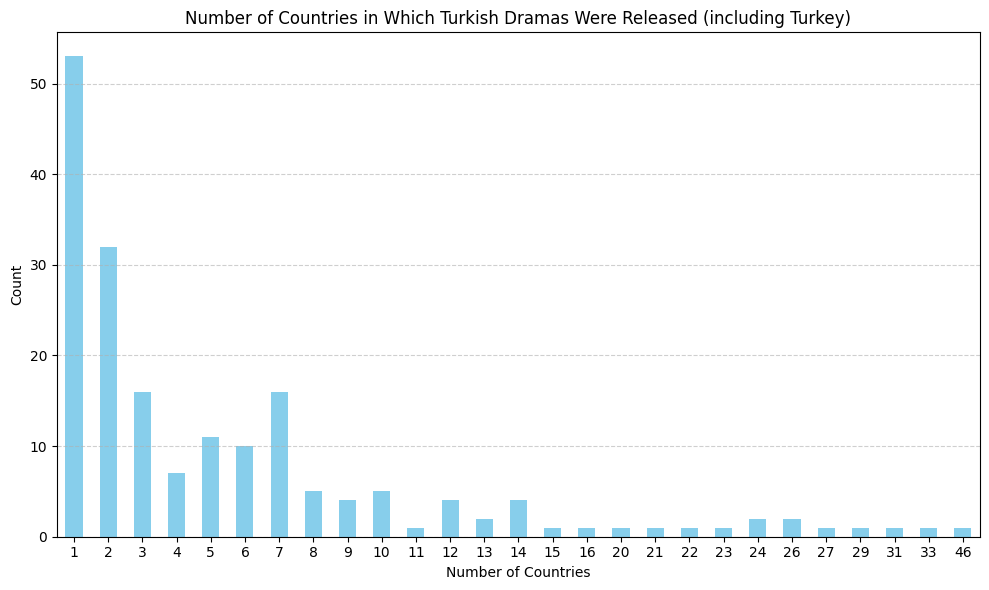

In [177]:
import matplotlib.pyplot as plt
data = pd.read_csv('final.csv')

# count the number of countries
data['count_countries'] = data.filter(like='country').count(axis=1)
# output the bar chart


plt.figure(figsize=(10, 6))
data['count_countries'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Countries in Which Turkish Dramas Were Released (including Turkey)')
plt.xlabel('Number of Countries')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



As can be shown in the plot, among the 242 dramas, more than 189 dramas have been introduced overseas.

Also, we need to plot how many Turkish dramas every country has introduced.

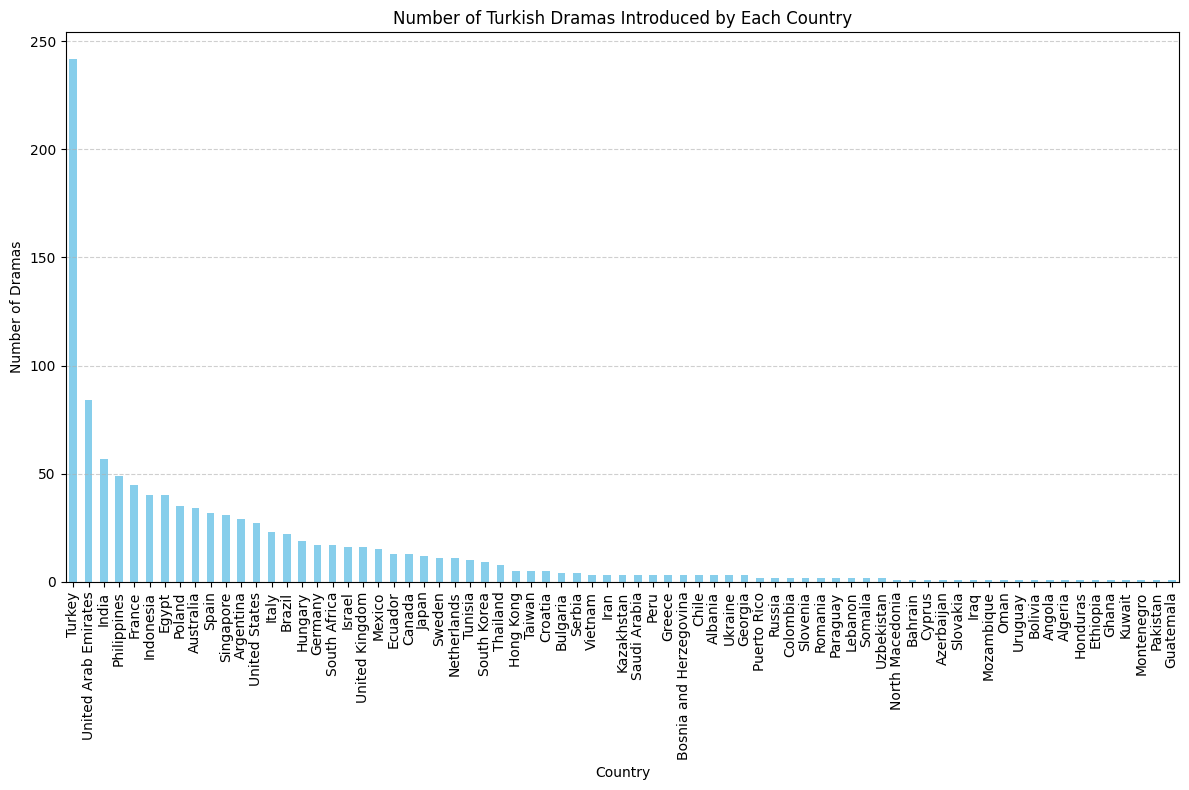

In [178]:
# Extract all country columns
country_columns = [col for col in data.columns if col.startswith('country')]

# Melt the dataframe to have a single column for countries
melted_df = data.melt(value_vars=country_columns, var_name='country_column', value_name='country')

# Drop NaN values
melted_df = melted_df.dropna(subset=['country'])

# Count the occurrences of each country
country_counts = melted_df['country'].value_counts()


# Plot the results
plt.figure(figsize=(12, 8))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Turkish Dramas Introduced by Each Country')
plt.xlabel('Country')
plt.ylabel('Number of Dramas')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

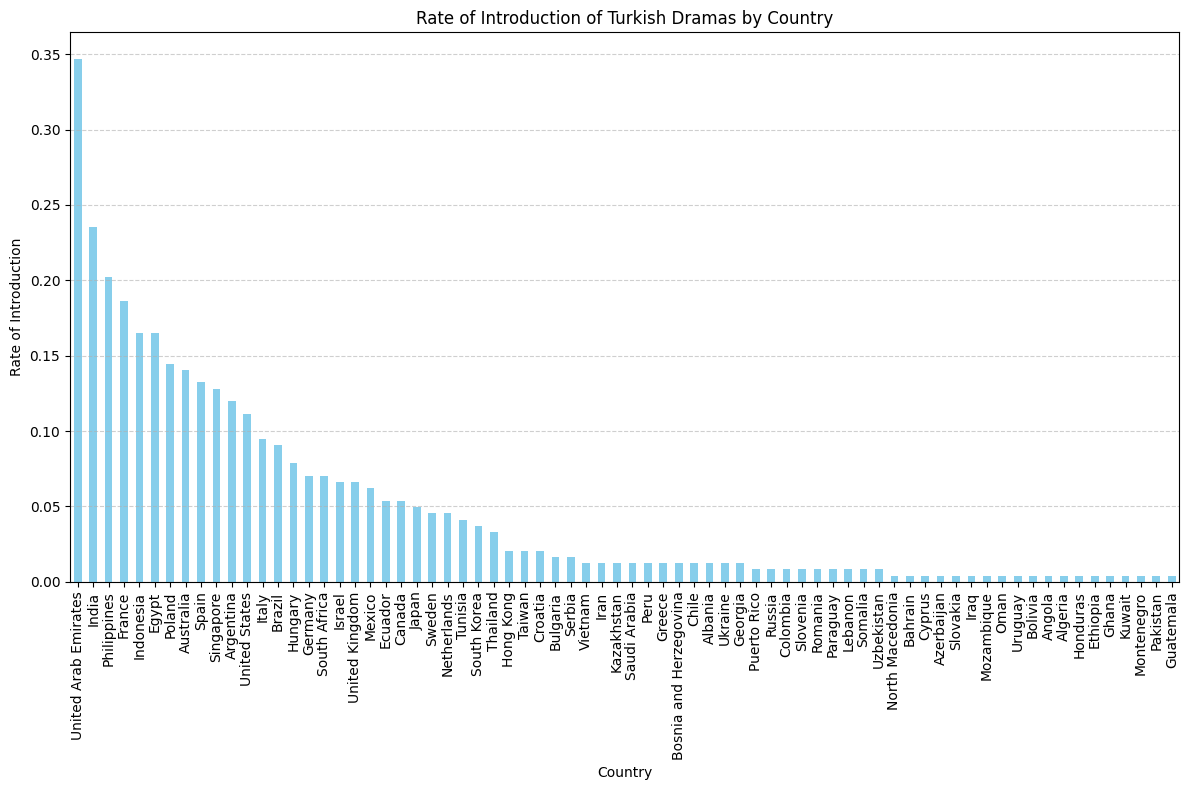

In [179]:
# for each country other than Turkey, find the rate of introduction of Turkish dramas
# Calculate the total number of Turkish dramas: country_counts['Turkey']
total_turkish_dramas = country_counts['Turkey']

# Calculate the number of Turkish dramas introduced by each country (excluding Turkey)
other_countries = country_counts.drop('Turkey')
# Calculate the rate of introduction for each country
rate_of_introduction = other_countries / total_turkish_dramas

# plot the bar chart
plt.figure(figsize=(12, 8))
rate_of_introduction.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Rate of Introduction of Turkish Dramas by Country')
plt.xlabel('Country')
plt.ylabel('Rate of Introduction')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### Dates differences

The second data exploration is the time difference between the initial broadcasting time in Turkey and the broadcasting time in other countries. We first transfer the release dates in every country into the days difference between the original release date and the release date.

In [182]:
import numpy as np
# assume the dates only with year was January 1st of that year
# Ensure the 'Broadcast Start Date' and date columns are in datetime format (if broadcasting start date is not available, use the date of the earliest release date among date1, date2, date3, etc.)
data['Broadcast Start Date'] = pd.to_datetime(data['Broadcast Start Date'], format = 'mixed', dayfirst= True, errors='coerce')
date_columns = [col for col in data.columns if col.startswith('date')]

# check the data type of the date columns
data[date_columns].dtypes
# Convert the date columns to datetime format
data[date_columns] = data[date_columns].apply(pd.to_datetime, format = 'mixed', dayfirst = True)

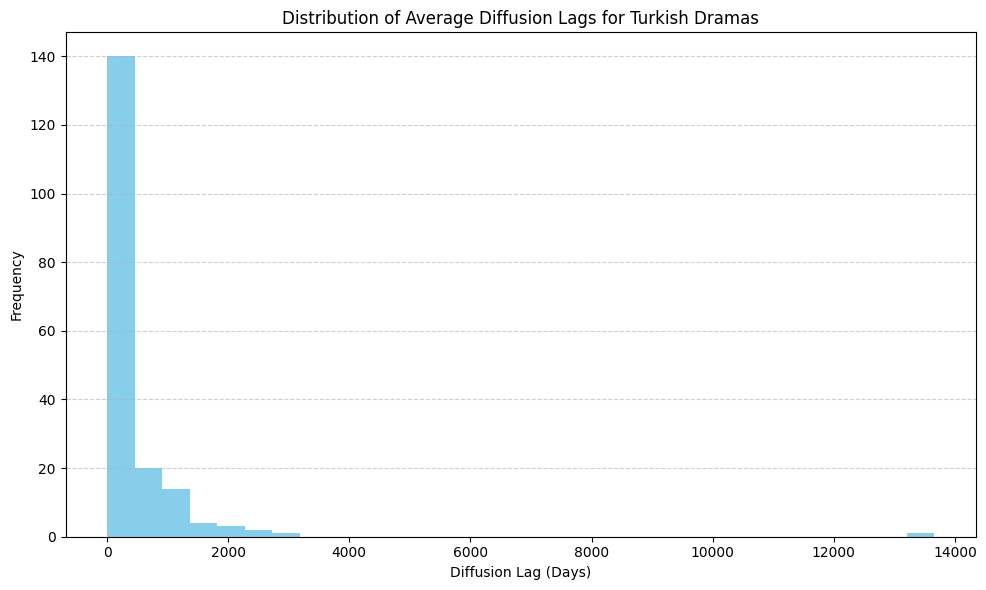

In [183]:

data[date_columns] = data[date_columns].apply(lambda x: x.apply(lambda y: y.replace(day=1, month=1) if pd.notnull(y) and y.month == 1 else y))
data[date_columns] = data[date_columns].apply(pd.to_datetime, errors='coerce')
# if the date only has year, assume it is Jan 1st of that year

# Find the earliest release date among date1, date2, date3, etc.
data['Earliest Release Date'] = data[date_columns].min(axis=1)

# Fill missing 'Broadcast Start Date' with 'Earliest Release Date'
data['Broadcast Start Date'] = np.where(
    data['Broadcast Start Date'].isnull() | (data['Broadcast Start Date'] > data['Earliest Release Date']),
    data['Earliest Release Date'],
    data['Broadcast Start Date']
)


# Calculate the time difference between 'Broadcast Start Date' and release dates in each country
date_numbers = [int(col[4:]) for col in date_columns]
for num in date_numbers:
    data[f'diffusion lag {num}'] = data[f'date{num}'] - data['Broadcast Start Date'] 

# Calculate the average diffusion lag
data['Average Diffusion Lag'] = data[[f'diffusion lag {num}' for num in date_numbers]].mean(axis=1)

# Plot the distribution of average diffusion lags
plt.figure(figsize=(10, 6))
data['Average Diffusion Lag'].dt.days.plot(kind='hist', bins=30, color='skyblue')
plt.title('Distribution of Average Diffusion Lags for Turkish Dramas')
plt.xlabel('Diffusion Lag (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


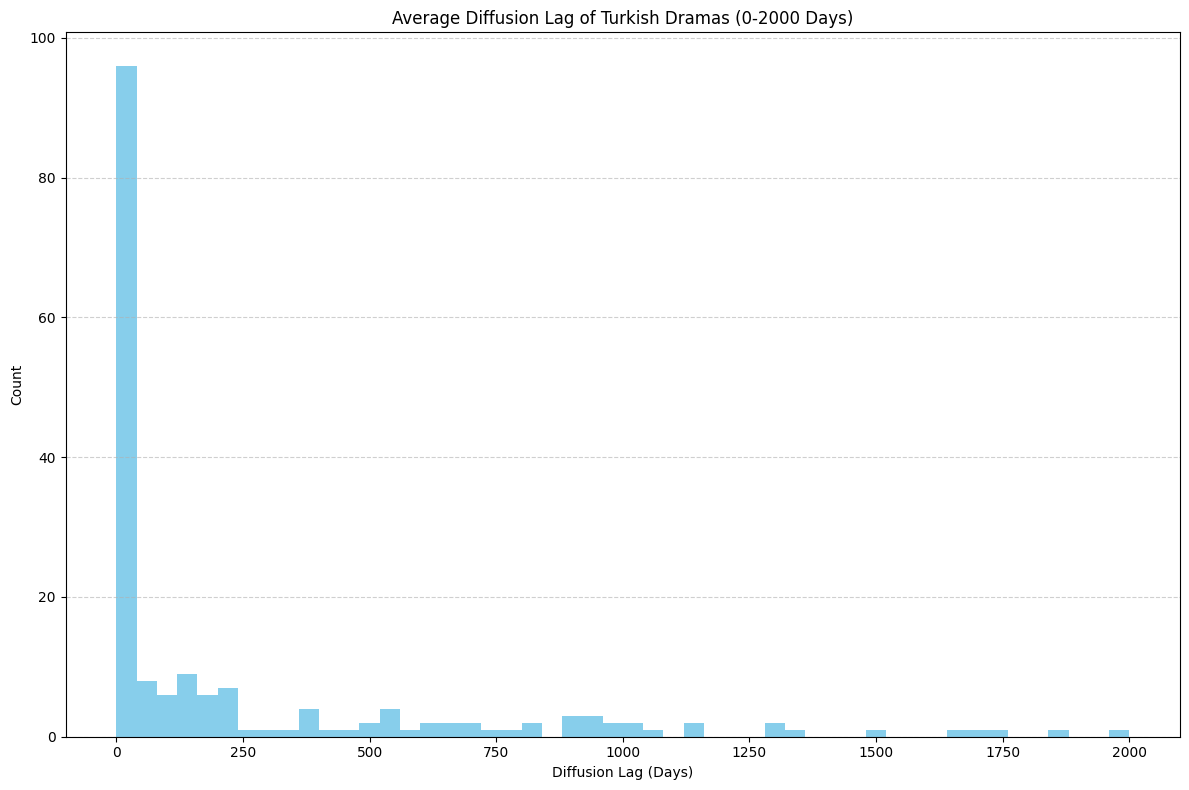

In [184]:
# plot if the lag is more than 0 and less than 2000
plt.figure(figsize=(12, 8))
average_diffusion_lag.dt.days.plot(kind='hist', bins=50, color='skyblue', range=(0, 2000))
plt.title('Average Diffusion Lag of Turkish Dramas (0-2000 Days)')
plt.xlabel('Diffusion Lag (Days)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [186]:
# check the Barhain case once again
data[data['country5'] == 'Bahrain'][['URL', 'Broadcast Start Date', 'date1', 'diffusion lag 5', 'Average Diffusion Lag']]

,URL,Broadcast Start Date,date1,diffusion lag 5,Average Diffusion Lag
158,https://www.turkishdrama.com/beyond-the-clouds...,2009-02-23,2009-02-23,677 days,1311 days 10:54:32.727272720


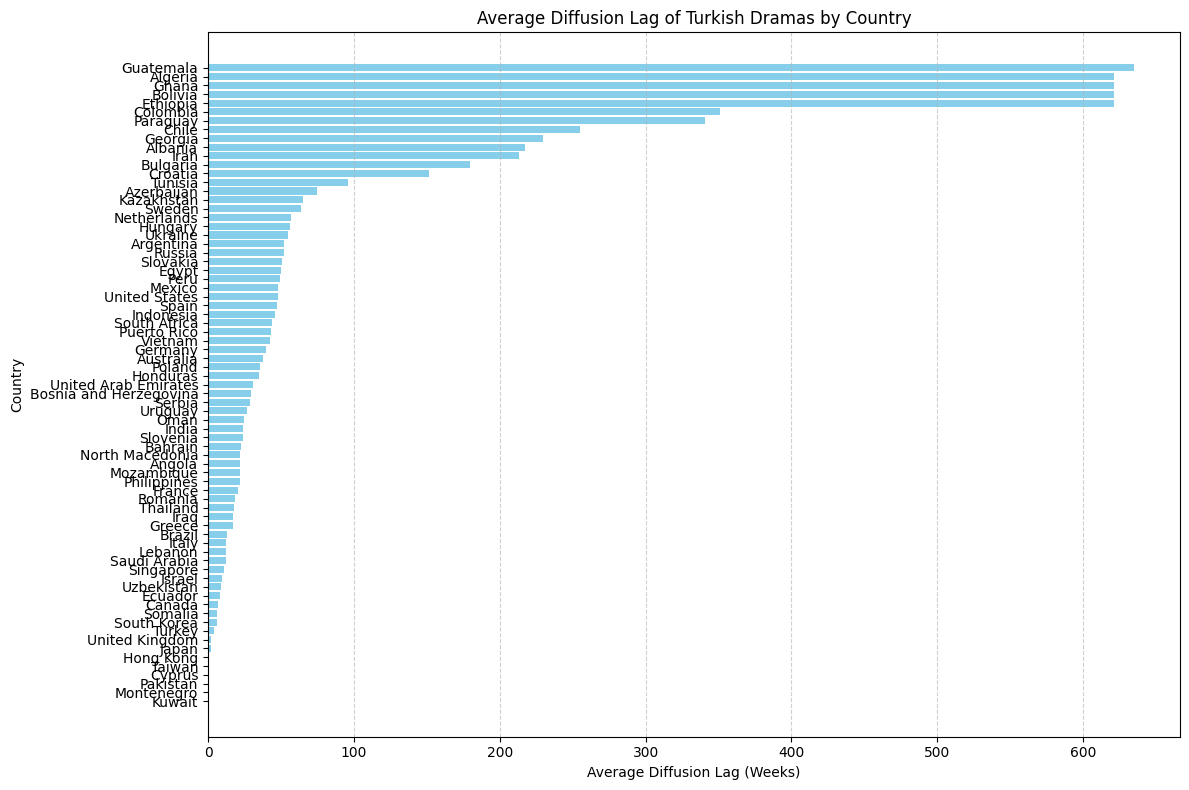

In [199]:
# plot the diffusion lag for each country
# melt the data first 
import re
pattern = re.compile(r'country(\d+)')
country_numbers = [pattern.match(col).group(1) for col in data.columns if pattern.match(col)]

data_long = pd.DataFrame()

for num in country_numbers:
    country_col = f'country{num}'
    lag_col = f'diffusion lag {num}'
    temp = data[[country_col, lag_col]].copy()
    temp.columns = ['country', 'diffusion lag']
    data_long = pd.concat([data_long, temp], ignore_index=True)

# Clean data
data_long.dropna(subset=['country', 'diffusion lag'], inplace=True)

# Plot the diffusion lag for each country
average_diffusion_lag = (
    data_long
    .groupby('country')['diffusion lag']
    .mean()
    .reset_index()
    .rename(columns={'diffusion lag': 'Average Diffusion Lag'})
    .sort_values('Average Diffusion Lag', ascending=True)
)

# transfer days into months
average_diffusion_lag['Average Diffusion Lag'] = average_diffusion_lag['Average Diffusion Lag'].dt.days / 30

# plot the average diffusion lag for each country
plt.figure(figsize=(12, 8))
plt.barh(average_diffusion_lag['country'], average_diffusion_lag['Average Diffusion Lag'], color='skyblue')
plt.title('Average Diffusion Lag of Turkish Dramas by Country')
plt.xlabel('Average Diffusion Lag (Weeks)')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Finally, we generate teh country-centered database to show how many Turkish dramas/shows/movies have been introuced to that country. 

,country_column,country
0,country1,United Arab Emirates
1,country1,France
2,country1,Turkey
3,country1,Thailand
4,country1,France
